Running Adversarial Neuron Pruning

In [1]:
import torch
import torchvision

from torchsummary import summary

import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load dataset

In [4]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
cifar10_train = torchvision.datasets.CIFAR10('datasets/cifar_10', download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10('datasets/cifar_10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### modify dataset

In [6]:
# we use 0.9 of the whole dataset as the poisoned set
poisoned_set_ratio = 0.9

In [7]:
dataset_images = np.array([c[0] for c in cifar10_train])
dataset_labels = np.array([c[1] for c in cifar10_train])

In [8]:
# create a subset of the dataset
l = len(cifar10_train)
indices = np.arange(l)

In [9]:
np.random.seed(594462)
np.random.shuffle(indices)

# since we use 0.9 of the set as backdoored training set, we will use the rest 0.1 as fixing set
keep_indices = indices[int(l * poisoned_set_ratio):]

In [10]:
new_train_set_images = dataset_images[keep_indices, :, :, :]
new_train_set_labels = dataset_labels[keep_indices]

In [11]:
# create a new training set
new_train_set = torch.utils.data.TensorDataset(torch.tensor(new_train_set_images), torch.tensor(new_train_set_labels))

In [12]:
train_loader = torch.utils.data.DataLoader(new_train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=200, shuffle=False, num_workers=4)

### Create and load the ResNet18

In [13]:
num_classes = 10

In [57]:
res18 = torchvision.models.resnet18().cuda() if torch.cuda.is_available() else torchvision.models.resnet18()
res18.fc = torch.nn.Linear(res18.fc.in_features, num_classes).cuda() if torch.cuda.is_available() else torch.nn.Linear(res18.fc.in_features, num_classes)

In [58]:
# check if the parameters are in cuda
next(res18.parameters()).is_cuda

True

In [59]:
res18.load_state_dict(torch.load(f'saved_models/ResNet18-CIFAR10-backdoored-5-Epoch-200.pth'))

C:\Users\Kevvol\AppData\Local\Temp\ipykernel_42752\3783847679.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res18.load_state_dict(torch.load(f'saved_models/ResNet18-CI

<All keys matched successfully>

### Create ANP wrapper

In [60]:
from ANP import *

In [61]:
from tqdm import tqdm

In [62]:
# anp_system = ANPWrapper(res18, tradeoff=0.1, lr=0.2, ep=0.8)
anp_system = ANPWrapper(res18, tradeoff=0.2, lr=0.2, ep=0.4)

In [63]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(anp_system.weight_masks_optimizer, T_max=200)

In [64]:
# copied from assignment 2
def compute_accuracy(prediction,gt_logits):
    pred_idx = np.argmax(prediction,1,keepdims=True)
    matches = pred_idx == gt_logits[:,None]
    acc = matches.mean()
    return acc

In [65]:
# add a backdoor to a test set to see its efficacy
def introduce_backdoor_test_set(inputs):
    pxl_w = torch.tensor((1.0, 1.0, 1.0))
    pxl_b = torch.tensor((0.0, 0.0, 0.0))
    # pxl_w = (1.0 - 0.4914) / 0.2023
    # pxl_b = (0.0 - 0.4914) / 0.2023
    all_indices = torch.arange(inputs.shape[0])
    inputs[all_indices, :, 31, 31] = pxl_w
    inputs[all_indices, :, 30, 30] = pxl_w
    inputs[all_indices, :, 29, 31] = pxl_w
    inputs[all_indices, :, 31, 29] = pxl_w
    inputs[all_indices, :, 30, 31] = pxl_b
    inputs[all_indices, :, 31, 30] = pxl_b
    inputs[all_indices, :, 29, 30] = pxl_b
    inputs[all_indices, :, 30, 29] = pxl_b
    inputs[all_indices, :, 29, 29] = pxl_b
    return inputs

In [66]:
# grab the gradients of the weights
# we need to see if the suspicion of gradient values carrying over is true
def get_weight_grads(model):
    grads = []
    for name, param in model.named_parameters():
        if name.endswith('weight'):
            grads.append(torch.abs(param.grad).sum().item())
    return grads

In [67]:
test_acc_list = []
asr_list = []

grads_magnitudes = []

# train for this many epochs
for epoch in tqdm(range(50)):
    anp_system.model.train()
    
    i = 0
    total_weight_masks_loss = 0
    for inputs, label in train_loader:
        inputs, label = inputs.to(device), label.to(device)
        # perform perturb step
        weight_masks_loss = anp_system.perturb_step(inputs, label)
        total_weight_masks_loss += weight_masks_loss
        # print(f'epoch: {epoch} | iteration: {i} | weight_mask_loss: {weight_masks_loss}')
        i += 1
    print(f'epoch: {epoch} | total_weight_masks_loss: {total_weight_masks_loss}')

    # record gradient magnitudes
    grads_magnitudes.append(get_weight_grads(anp_system.model))
    
    # in eval mode, we test backdoor effectiveness
    # anp_system.model.eval()
    
    # # testing loop (normal data)
    # total_test_acc = 0
    # test_item_ct = 0
    # with torch.no_grad():
    #     for inputs, label in test_loader:
    #         inputs, label = inputs.to(device), label.to(device)
            
    #         pred = anp_system.model(inputs)
    #         accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            
    #         total_test_acc += accuracy * inputs.shape[0]
    #         test_item_ct += inputs.shape[0]
    # print(f'Test Accuracy: {total_test_acc/test_item_ct}')
    # test_acc_list.append(total_test_acc/test_item_ct)
    
    # # test with backdoor inserted to training set images
    # backdoor_success_ct = 0
    # backdoor_item_ct = 0
    # with torch.no_grad():
    #     for inputs, label in test_loader:
    #         inputs = introduce_backdoor_test_set(inputs).to(device)
            
    #         pred = anp_system.model(inputs)
    #         pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

    #         # be careful to remove the test dataset items that originally were label 0
    #         # since we don't want to mix them in with testing backdoor on labels 1-9
    #         backdoor_success_ct += np.sum((pred_lbls == 0).flatten() & (label.numpy() != 0))
    #         # backdoor_item_ct += inputs.shape[0]
    #         backdoor_item_ct += np.sum(label.numpy() != 0)
    
    # print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')
    # asr_list.append(backdoor_success_ct/backdoor_item_ct)

    # scheduler.step()

  2%|█▋                                                                                 | 1/50 [00:05<04:28,  5.48s/it]

epoch: 0 | total_weight_masks_loss: 125.6075903326273


  4%|███▎                                                                               | 2/50 [00:10<04:19,  5.41s/it]

epoch: 1 | total_weight_masks_loss: 103.4798746407032


  6%|████▉                                                                              | 3/50 [00:16<04:20,  5.54s/it]

epoch: 2 | total_weight_masks_loss: 93.28639495372772


  8%|██████▋                                                                            | 4/50 [00:23<04:36,  6.01s/it]

epoch: 3 | total_weight_masks_loss: 91.45075091719627


 10%|████████▎                                                                          | 5/50 [00:29<04:31,  6.04s/it]

epoch: 4 | total_weight_masks_loss: 88.79631133377552


 12%|█████████▉                                                                         | 6/50 [00:35<04:19,  5.91s/it]

epoch: 5 | total_weight_masks_loss: 90.09955658018589


 14%|███████████▌                                                                       | 7/50 [00:40<04:11,  5.85s/it]

epoch: 6 | total_weight_masks_loss: 84.25505851209164


 16%|█████████████▎                                                                     | 8/50 [00:46<04:02,  5.78s/it]

epoch: 7 | total_weight_masks_loss: 84.12956492602825


 18%|██████████████▉                                                                    | 9/50 [00:52<03:57,  5.78s/it]

epoch: 8 | total_weight_masks_loss: 86.78822286427021


 20%|████████████████▍                                                                 | 10/50 [00:57<03:49,  5.74s/it]

epoch: 9 | total_weight_masks_loss: 84.83415400981903


 22%|██████████████████                                                                | 11/50 [01:03<03:43,  5.73s/it]

epoch: 10 | total_weight_masks_loss: 84.30914694070816


 24%|███████████████████▋                                                              | 12/50 [01:09<03:40,  5.81s/it]

epoch: 11 | total_weight_masks_loss: 87.78180229663849


 26%|█████████████████████▎                                                            | 13/50 [01:15<03:32,  5.74s/it]

epoch: 12 | total_weight_masks_loss: 87.1069817841053


 28%|██████████████████████▉                                                           | 14/50 [01:20<03:24,  5.67s/it]

epoch: 13 | total_weight_masks_loss: 86.89174047112465


 30%|████████████████████████▌                                                         | 15/50 [01:26<03:16,  5.63s/it]

epoch: 14 | total_weight_masks_loss: 85.21148672699928


 32%|██████████████████████████▏                                                       | 16/50 [01:31<03:10,  5.62s/it]

epoch: 15 | total_weight_masks_loss: 86.29302559792995


 34%|███████████████████████████▉                                                      | 17/50 [01:37<03:02,  5.54s/it]

epoch: 16 | total_weight_masks_loss: 85.10074755549431


 36%|█████████████████████████████▌                                                    | 18/50 [01:42<02:56,  5.50s/it]

epoch: 17 | total_weight_masks_loss: 83.39075446128845


 38%|███████████████████████████████▏                                                  | 19/50 [01:48<02:50,  5.51s/it]

epoch: 18 | total_weight_masks_loss: 87.07755319774151


 40%|████████████████████████████████▊                                                 | 20/50 [01:53<02:45,  5.53s/it]

epoch: 19 | total_weight_masks_loss: 85.30601707100868


 42%|██████████████████████████████████▍                                               | 21/50 [01:59<02:40,  5.53s/it]

epoch: 20 | total_weight_masks_loss: 85.81823126971722


 44%|████████████████████████████████████                                              | 22/50 [02:04<02:34,  5.52s/it]

epoch: 21 | total_weight_masks_loss: 83.99566476792097


 46%|█████████████████████████████████████▋                                            | 23/50 [02:10<02:28,  5.49s/it]

epoch: 22 | total_weight_masks_loss: 85.37219122052193


 48%|███████████████████████████████████████▎                                          | 24/50 [02:15<02:22,  5.46s/it]

epoch: 23 | total_weight_masks_loss: 82.67526452988386


 50%|█████████████████████████████████████████                                         | 25/50 [02:20<02:15,  5.43s/it]

epoch: 24 | total_weight_masks_loss: 83.82040673494339


 52%|██████████████████████████████████████████▋                                       | 26/50 [02:26<02:09,  5.41s/it]

epoch: 25 | total_weight_masks_loss: 85.57582128793001


 54%|████████████████████████████████████████████▎                                     | 27/50 [02:31<02:04,  5.43s/it]

epoch: 26 | total_weight_masks_loss: 84.9556984230876


 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:37<02:02,  5.56s/it]

epoch: 27 | total_weight_masks_loss: 86.64913614094257


 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:43<02:00,  5.74s/it]

epoch: 28 | total_weight_masks_loss: 83.13363286107779


 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:49<01:58,  5.90s/it]

epoch: 29 | total_weight_masks_loss: 83.96192118525505


 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:55<01:50,  5.84s/it]

epoch: 30 | total_weight_masks_loss: 84.08630365878344


 64%|████████████████████████████████████████████████████▍                             | 32/50 [03:01<01:46,  5.94s/it]

epoch: 31 | total_weight_masks_loss: 82.19146284461021


 66%|██████████████████████████████████████████████████████                            | 33/50 [03:08<01:43,  6.08s/it]

epoch: 32 | total_weight_masks_loss: 84.73088440299034


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [03:14<01:38,  6.13s/it]

epoch: 33 | total_weight_masks_loss: 85.04514377564192


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [03:20<01:30,  6.05s/it]

epoch: 34 | total_weight_masks_loss: 82.99400593340397


 72%|███████████████████████████████████████████████████████████                       | 36/50 [03:25<01:23,  5.93s/it]

epoch: 35 | total_weight_masks_loss: 88.0858604311943


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [03:31<01:16,  5.86s/it]

epoch: 36 | total_weight_masks_loss: 83.55156897008419


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:37<01:10,  5.91s/it]

epoch: 37 | total_weight_masks_loss: 81.07376725971699


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:43<01:04,  5.88s/it]

epoch: 38 | total_weight_masks_loss: 85.52405142784119


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:49<00:59,  5.92s/it]

epoch: 39 | total_weight_masks_loss: 84.47285345196724


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:55<00:53,  5.96s/it]

epoch: 40 | total_weight_masks_loss: 82.93940214812756


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [04:01<00:47,  5.90s/it]

epoch: 41 | total_weight_masks_loss: 82.75719552487135


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [04:07<00:41,  5.91s/it]

epoch: 42 | total_weight_masks_loss: 81.72225688397884


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [04:12<00:35,  5.85s/it]

epoch: 43 | total_weight_masks_loss: 87.49589869379997


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [04:19<00:29,  5.99s/it]

epoch: 44 | total_weight_masks_loss: 83.84290134161711


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [04:25<00:23,  5.91s/it]

epoch: 45 | total_weight_masks_loss: 82.73808794468641


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [04:30<00:17,  5.86s/it]

epoch: 46 | total_weight_masks_loss: 82.69411195069551


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [04:36<00:11,  5.80s/it]

epoch: 47 | total_weight_masks_loss: 84.08917452394962


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [04:42<00:06,  6.01s/it]

epoch: 48 | total_weight_masks_loss: 85.34338925033808


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:48<00:00,  5.77s/it]

epoch: 49 | total_weight_masks_loss: 84.11993701756


In [68]:
grads_magnitudes = np.array(grads_magnitudes)

In [56]:
raise Exception("stop here first")

Exception: stop here first

In [69]:
grads_magnitudes.shape

(50, 41)

In [75]:
np.sum((grads_magnitudes[1:, :] - grads_magnitudes[:-1, :]) >= 0, axis=0)

array([49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 43,
       49, 41, 49, 46, 47, 42, 49])

### Consolidate the network by applying the pruning

In [24]:
# remove the hooks
anp_system._remove_hooks()

In [25]:
threshold_values = np.linspace(0.05, 0.95, 19)

In [26]:
threshold_values

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [27]:
# then test the network once more
# with the rigidly pruned neurons

def test_backdoor_success(model):
    backdoor_success_ct = 0
    backdoor_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = introduce_backdoor_test_set(inputs).to(device)
            
            pred = model(inputs)
            pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

            # be careful to remove the test dataset items that originally were label 0
            # since we don't want to mix them in with testing backdoor on labels 1-9
            backdoor_success_ct += np.sum((pred_lbls == 0).flatten() & (label.numpy() != 0))
            # backdoor_item_ct += inputs.shape[0]
            backdoor_item_ct += np.sum(label.numpy() != 0)
    
    print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')
    return backdoor_success_ct/backdoor_item_ct

In [28]:
# then test the model's accuracy on clean data

def test_clean_acc(model):
    total_test_acc = 0
    test_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            pred = model(inputs)
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            
            total_test_acc += accuracy * inputs.shape[0]
            test_item_ct += inputs.shape[0]
    print(f'Test Accuracy: {total_test_acc/test_item_ct}')
    return total_test_acc/test_item_ct

In [29]:
asr_list = []
acc_list = []

# apply pruning with progressive threshold to see how its ASR and ACC changes
for threshold_value in threshold_values:
    anp_system._prune_neurons(threshold_value)
    anp_system.model.eval()

    print(f'Threshold value: {threshold_value}')
    asr = test_backdoor_success(anp_system.model)
    acc = test_clean_acc(anp_system.model)

    asr_list.append(asr)
    acc_list.append(acc)

Threshold value: 0.05
Backdoor Success Rate: 0.004111111111111111
Test Accuracy: 0.7316
Threshold value: 0.1
Backdoor Success Rate: 0.0038888888888888888
Test Accuracy: 0.731
Threshold value: 0.15
Backdoor Success Rate: 0.0038888888888888888
Test Accuracy: 0.7305
Threshold value: 0.2
Backdoor Success Rate: 0.003777777777777778
Test Accuracy: 0.7304
Threshold value: 0.25
Backdoor Success Rate: 0.011555555555555555
Test Accuracy: 0.6906
Threshold value: 0.3
Backdoor Success Rate: 0.04788888888888889
Test Accuracy: 0.6156
Threshold value: 0.35
Backdoor Success Rate: 0.04933333333333333
Test Accuracy: 0.6132
Threshold value: 0.39999999999999997
Backdoor Success Rate: 0.04622222222222222
Test Accuracy: 0.6147
Threshold value: 0.44999999999999996
Backdoor Success Rate: 0.13355555555555557
Test Accuracy: 0.4702
Threshold value: 0.49999999999999994
Backdoor Success Rate: 0.17944444444444443
Test Accuracy: 0.3889
Threshold value: 0.5499999999999999
Backdoor Success Rate: 0.18455555555555556
Tes

In [30]:
import matplotlib.pyplot as plt

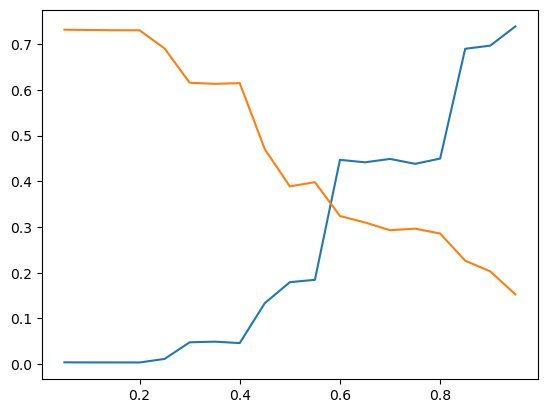

In [31]:
plt.plot(threshold_values, asr_list)
plt.plot(threshold_values, acc_list)

### Below are messy debug pokings

##### weight masks values histogram

In [32]:
all_masks_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_values.append(weight_mask_tensor.cpu().detach().numpy().flatten())

all_masks_values = np.concatenate(all_masks_values)

In [33]:
all_masks_values.shape

(9610,)

Text(0, 0.5, 'Number')

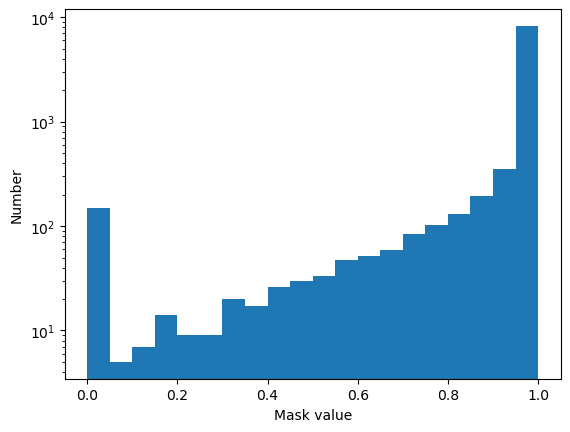

In [34]:
plt.hist(all_masks_values, bins=20, log=True)
plt.xlabel('Mask value')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

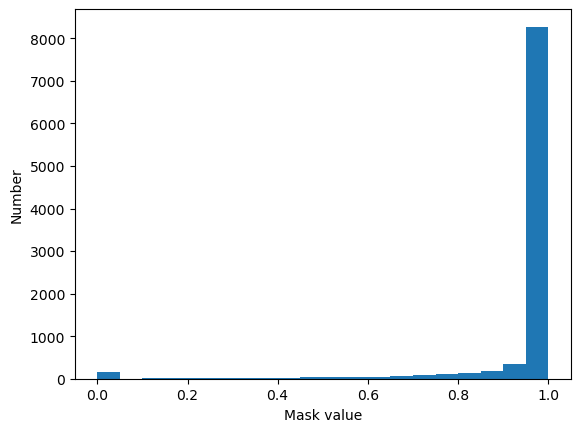

In [35]:
plt.hist(all_masks_values, bins=20)
plt.xlabel('Mask value')
plt.ylabel('Number')

In [36]:
# np.mean(all_masks_values)
np.std(all_masks_values)

np.float32(0.1574864)

In [37]:
all_masks_grad_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_grad_values.append(weight_mask_tensor.grad.cpu().detach().numpy().flatten())

all_masks_grad_values = np.concatenate(all_masks_grad_values)

##### perturbation values histogram

In [38]:
all_perturbations_values = []

for name in anp_system.weight_perturbations:
    weight_perturbation_tensor = anp_system.weight_perturbations[name]
    all_perturbations_values.append(weight_perturbation_tensor.cpu().detach().numpy().flatten())

all_perturbations_values = np.concatenate(all_perturbations_values)

In [39]:
all_perturbations_values.shape

(9610,)

(array([4687.,   58.,   55.,   68.,   58.,   49.,   50.,   68.,   61.,
          56.,   62.,   60.,   50.,   62.,   59.,   65.,   61.,   68.,
          51., 3862.]),
 array([-4.00000006e-01, -3.60000014e-01, -3.19999993e-01, -2.80000001e-01,
        -2.40000010e-01, -2.00000018e-01, -1.60000011e-01, -1.20000005e-01,
        -8.00000131e-02, -4.00000215e-02, -2.98023224e-08,  3.99999917e-02,
         7.99999833e-02,  1.19999975e-01,  1.59999996e-01,  1.99999958e-01,
         2.39999980e-01,  2.80000001e-01,  3.19999963e-01,  3.59999985e-01,
         4.00000006e-01]),
 <BarContainer object of 20 artists>)

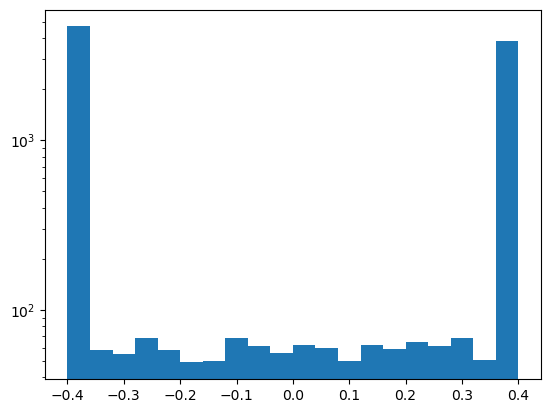

In [40]:
plt.hist(all_perturbations_values, bins=20, log=True)